In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from collections import defaultdict

In [2]:
df_us = pd.read_csv("clean_STU_QQQ_US.tsv", sep='\t')
# df_all = pd.read_csv("clean_STU_QQQ.tsv", sep='\t')

In [3]:
df_us = df_us.dropna(axis=1, how='all')

In [4]:
# CONVERT to categorical
columns = [
    "CNTSCHID", # Intl. School ID
    "CNTSTUID", # Student ID
    "CYC", # PISA Assessment Cycle (2 digits + 2 character Assessment type - MS/FT)
    "VER_DAT", # Date of the database creation
]

for col in columns:
    df_us[col] = df_us[col].astype('category')

In [5]:
df_us.describe(include=['category'])

,CNTSCHID,CNTSTUID,CYC,VER_DAT
count,4552.0,4552.0,4552,4552
unique,154.0,4552.0,1,3
top,84000061.0,84008157.0,08MS,02MAY23:13:08:35
freq,40.0,1.0,4552,2331


In [6]:
encoder = ce.OrdinalEncoder(cols=['CNTSCHID'])
ord_encoded = encoder.fit_transform(df_us['CNTSCHID'])

In [7]:
df_us_numeric = df_us.select_dtypes(include=['int8', 'float64', 'Int64'])

In [8]:
df_us_filtered = df_us_numeric.drop(['Unnamed: 0'], axis=1)
# Drop columns that start with "Option_"
df_us_filtered = df_us_filtered.drop(df_us_filtered.filter(regex='^Option_').columns, axis=1)
df_us_filtered = df_us_filtered.drop(df_us_filtered.filter(regex='^W_').columns, axis=1) #drop replicate weight as not important 

df_us_filtered = df_us_filtered.drop(['OECD', 'ADMINMODE', 'UNIT', 'WVARSTRR'], axis=1)

df_us_filtered = df_us_filtered.drop(['ST001D01T', 'ST003D02T', 'ST003D03T', 'ST004D01T'], axis=1) #related to age and gender of student
# Calculate the mean and standard deviation for each column
means = df_us_filtered.mean()
std_devs = df_us_filtered.std()

# Combine into a summary DataFrame
summary_stats = pd.DataFrame({'Mean': means, 'Standard Deviation': std_devs})

# Identify columns with zero standard deviation
constant_columns = summary_stats[summary_stats['Standard Deviation'] == 0].index.tolist()

# Drop columns with zero standard deviation
df_us_filtered = df_us_filtered.drop(columns=constant_columns)

pd.options.display.max_columns = None  # Show all columns
print(df_us_filtered.head())

   ST250Q01JA  ST250Q02JA  ST250Q03JA  ST250Q04JA  ST250Q05JA  ST251Q01JA  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           1   
2           0           0           0           0           0           0   
3           0           0           1           0           0           1   
4           0           0           0           0           0           2   

   ST251Q02JA  ST251Q03JA  ST251Q04JA  ST251Q06JA  ST253Q01JA  ST254Q01JA  \
0           3           0           0           0           0           2   
1           3           0           0           1           0           0   
2           3           0           0           2           0           0   
3           3           1           1           3           2           2   
4           3           2           2           3           0           1   

   ST254Q02JA  ST254Q03JA  ST254Q04JA  ST254Q05JA  ST254Q06JA  ST255Q01JA 

In [9]:
df_us_filtered = df_us_filtered.fillna(df_us_filtered.median())
df = df_us_filtered.join(ord_encoded.astype('category'))
df.describe()

,ST250Q01JA,ST250Q02JA,ST250Q03JA,ST250Q04JA,ST250Q05JA,ST251Q01JA,ST251Q02JA,ST251Q03JA,ST251Q04JA,ST251Q06JA,ST253Q01JA,ST254Q01JA,ST254Q02JA,ST254Q03JA,ST254Q04JA,ST254Q05JA,ST254Q06JA,ST255Q01JA,ST256Q01JA,ST256Q02JA,ST256Q03JA,ST256Q06JA,ST256Q07JA,ST256Q08JA,ST256Q09JA,ST256Q10JA,ST230Q01JA,ST005Q01JA,ST006Q01JA,ST006Q02JA,ST006Q03JA,ST006Q04JA,ST006Q05JA,ST007Q01JA,ST008Q01JA,ST008Q02JA,ST008Q03JA,ST008Q04JA,ST008Q05JA,ST258Q01JA,ST259Q01JA,ST259Q02JA,ST019AQ01T,ST019BQ01T,ST019CQ01T,ST021Q01TA,ST022Q01TA,ST226Q01JA,ST125Q01NA,ST126Q01TA,ST127Q01TA,ST127Q02TA,ST127Q03TA,ST260Q01JA,ST260Q02JA,ST260Q03JA,ST261Q01JA,ST261Q02JA,ST261Q03JA,ST261Q04JA,ST261Q05JA,ST261Q06JA,ST261Q07JA,ST261Q08JA,ST261Q09JA,ST261Q10JA,ST261Q11JA,ST062Q01TA,ST062Q02TA,ST062Q03TA,ST267Q01JA,ST267Q02JA,ST267Q03JA,ST267Q04JA,ST267Q05JA,ST267Q06JA,ST267Q07JA,ST267Q08JA,ST034Q01TA,ST034Q02TA,ST034Q03TA,ST034Q04TA,ST034Q05TA,ST034Q06TA,ST038Q03NA,ST038Q04NA,ST038Q05NA,ST038Q06NA,ST038Q07NA,ST038Q08NA,ST038Q09JA,ST038Q10JA,ST038Q11JA,ST265Q01JA,ST265Q02JA,ST265Q03JA,ST265Q04JA,ST266Q01JA,ST266Q02JA,ST266Q03JA,ST266Q04JA,ST266Q05JA,ST294Q01JA,ST294Q02JA,ST294Q03JA,ST294Q04JA,ST294Q05JA,ST295Q01JA,ST295Q02JA,ST295Q03JA,ST295Q04JA,ST295Q05JA,ST263Q02JA,ST263Q04JA,ST263Q06JA,ST059Q01TA,ST059Q02JA,ST296Q01JA,ST296Q02JA,ST296Q03JA,ST296Q04JA,ST273Q01JA,ST273Q02JA,ST273Q03JA,ST273Q04JA,ST273Q05JA,ST273Q06JA,ST273Q07JA,ST270Q01JA,ST270Q02JA,ST270Q03JA,ST270Q04JA,ST285Q01JA,ST285Q02JA,ST285Q03JA,ST285Q04JA,ST285Q05JA,ST285Q06JA,ST285Q07JA,ST285Q08JA,ST285Q09JA,ST283Q01JA,ST283Q02JA,ST283Q03JA,ST283Q04JA,ST283Q05JA,ST283Q06JA,ST283Q07JA,ST283Q08JA,ST283Q09JA,ST275Q01WA,ST275Q02WA,ST275Q03WA,ST275Q04WA,ST275Q05WA,ST275Q06WA,ST275Q07WA,ST275Q08WA,ST275Q09WA,ST276Q01JA,ST276Q02JA,ST276Q03JA,ST276Q04JA,ST276Q05JA,ST276Q06JA,ST276Q07JA,ST276Q08JA,ST276Q09JA,ST276Q10JA,ST268Q01JA,ST268Q02JA,ST268Q03JA,ST268Q04JA,ST268Q05JA,ST268Q06JA,ST268Q07JA,ST268Q08JA,ST268Q09JA,ST290Q01WA,ST290Q02WA,ST290Q03WA,ST290Q04WA,ST290Q05WA,ST290Q06WA,ST290Q07WA,ST290Q08WA,ST290Q09WA,ST291Q01JA,ST291Q02JA,ST291Q03JA,ST291Q04JA,ST291Q05JA,ST291Q06JA,ST291Q07JA,ST291Q08JA,ST291Q09JA,ST291Q10JA,ST289Q01WA,ST289Q02JA,ST289Q03WA,ST289Q04JA,ST289Q05WA,ST289Q06JA,ST289Q07JA,ST289Q08WA,ST289Q09WA,ST289Q10WA,ST289Q11WA,ST289Q14JA,ST293Q01JA,ST293Q02JA,ST293Q03JA,ST293Q04JA,ST293Q05JA,ST293Q06JA,ST293Q07JA,ST293Q08JA,ST293Q09JA,ST292Q01JA,ST292Q02JA,ST292Q03JA,ST292Q04JA,ST292Q05JA,ST292Q06JA,ST297Q01JA,ST297Q03JA,ST297Q05JA,ST297Q06JA,ST297Q07JA,ST297Q09JA,ST300Q01JA,ST300Q02JA,ST300Q03JA,ST300Q04JA,ST300Q05JA,ST300Q06JA,ST300Q07JA,ST300Q08JA,ST300Q09JA,ST300Q10JA,ST327Q01JA,ST327Q03JA,ST327Q04JA,ST327Q05JA,ST327Q06JA,ST327Q07JA,ST327Q08JA,ST330Q01WA,ST330Q02WA,ST330Q03WA,ST330Q04WA,ST330Q05WA,ST330Q06WA,ST330Q07WA,ST330Q08WA,ST330Q09WA,ST330Q11WA,ST324Q02JA,ST324Q04JA,ST324Q05JA,ST324Q07JA,ST324Q10JA,ST324Q11JA,ST324Q12JA,ST324Q13JA,ST324Q14JA,ST347Q01JA,ST347Q02JA,ST348Q01JA,ST348Q02JA,ST348Q03JA,ST348Q04JA,ST348Q05JA,ST348Q06JA,ST348Q07JA,ST348Q08JA,ST349Q01JA,ST350Q01JA,ST351Q01JA,ST351Q02JA,ST351Q03JA,ST351Q04JA,ST351Q05JA,ST351Q06JA,ST351Q07JA,ST351Q08JA,ST352Q01JA,ST352Q02JA,ST352Q03JA,ST352Q04JA,ST352Q05JA,ST352Q06JA,ST352Q07JA,ST352Q08JA,ST353Q01JA,ST353Q02JA,ST353Q03JA,ST353Q04JA,ST353Q05JA,ST353Q06JA,ST353Q07JA,ST353Q08JA,ST354Q01JA,ST354Q02JA,ST354Q03JA,ST354Q04JA,ST354Q05JA,ST354Q06JA,ST354Q07JA,ST354Q08JA,ST354Q09JA,ST354Q10JA,ST355Q01JA,ST355Q02JA,ST355Q03JA,ST355Q04JA,ST355Q05JA,ST355Q06JA,ST355Q07JA,ST355Q08JA,ST356Q01JA,ST331Q01JA,ST331Q02JA,ST331Q03JA,FL150Q01TA,FL150Q02TA,FL150Q03TA,FL164Q01HA,FL164Q02HA,FL164Q03HA,FL164Q04HA,FL164Q05HA,FL164Q06HA,FL164Q07HA,FL164Q08HA,FL164Q09HA,FL164Q10HA,FL164Q11HA,FL164Q12HA,FL164Q13HA,FL164Q14HA,FL164Q15HA,FL164Q16HA,FL166Q01HA,FL166Q02HA,FL166Q03HA,FL166Q05HA,FL166Q06HA,FL166Q07HA,FL174Q01JA,FL174Q02JA,FL174Q03JA,FL174Q04JA,FL174Q05JA,FL174Q06JA,FL174Q07JA,FL167Q01HA,FL167Q02HA,FL167Q06JA,FL167Q03HA,FL167Q04HA,FL167Q05HA,FL167Q07JA,FL170Q

In [10]:
df

,ST250Q01JA,ST250Q02JA,ST250Q03JA,ST250Q04JA,ST250Q05JA,ST251Q01JA,ST251Q02JA,ST251Q03JA,ST251Q04JA,ST251Q06JA,ST253Q01JA,ST254Q01JA,ST254Q02JA,ST254Q03JA,ST254Q04JA,ST254Q05JA,ST254Q06JA,ST255Q01JA,ST256Q01JA,ST256Q02JA,ST256Q03JA,ST256Q06JA,ST256Q07JA,ST256Q08JA,ST256Q09JA,ST256Q10JA,ST230Q01JA,ST005Q01JA,ST006Q01JA,ST006Q02JA,ST006Q03JA,ST006Q04JA,ST006Q05JA,ST007Q01JA,ST008Q01JA,ST008Q02JA,ST008Q03JA,ST008Q04JA,ST008Q05JA,ST258Q01JA,ST259Q01JA,ST259Q02JA,ST019AQ01T,ST019BQ01T,ST019CQ01T,ST021Q01TA,ST022Q01TA,ST226Q01JA,ST125Q01NA,ST126Q01TA,ST127Q01TA,ST127Q02TA,ST127Q03TA,ST260Q01JA,ST260Q02JA,ST260Q03JA,ST261Q01JA,ST261Q02JA,ST261Q03JA,ST261Q04JA,ST261Q05JA,ST261Q06JA,ST261Q07JA,ST261Q08JA,ST261Q09JA,ST261Q10JA,ST261Q11JA,ST062Q01TA,ST062Q02TA,ST062Q03TA,ST267Q01JA,ST267Q02JA,ST267Q03JA,ST267Q04JA,ST267Q05JA,ST267Q06JA,ST267Q07JA,ST267Q08JA,ST034Q01TA,ST034Q02TA,ST034Q03TA,ST034Q04TA,ST034Q05TA,ST034Q06TA,ST038Q03NA,ST038Q04NA,ST038Q05NA,ST038Q06NA,ST038Q07NA,ST038Q08NA,ST038Q09JA,ST038Q10JA,ST038Q11JA,ST265Q01JA,ST265Q02JA,ST265Q03JA,ST265Q04JA,ST266Q01JA,ST266Q02JA,ST266Q03JA,ST266Q04JA,ST266Q05JA,ST294Q01JA,ST294Q02JA,ST294Q03JA,ST294Q04JA,ST294Q05JA,ST295Q01JA,ST295Q02JA,ST295Q03JA,ST295Q04JA,ST295Q05JA,ST263Q02JA,ST263Q04JA,ST263Q06JA,ST059Q01TA,ST059Q02JA,ST296Q01JA,ST296Q02JA,ST296Q03JA,ST296Q04JA,ST273Q01JA,ST273Q02JA,ST273Q03JA,ST273Q04JA,ST273Q05JA,ST273Q06JA,ST273Q07JA,ST270Q01JA,ST270Q02JA,ST270Q03JA,ST270Q04JA,ST285Q01JA,ST285Q02JA,ST285Q03JA,ST285Q04JA,ST285Q05JA,ST285Q06JA,ST285Q07JA,ST285Q08JA,ST285Q09JA,ST283Q01JA,ST283Q02JA,ST283Q03JA,ST283Q04JA,ST283Q05JA,ST283Q06JA,ST283Q07JA,ST283Q08JA,ST283Q09JA,ST275Q01WA,ST275Q02WA,ST275Q03WA,ST275Q04WA,ST275Q05WA,ST275Q06WA,ST275Q07WA,ST275Q08WA,ST275Q09WA,ST276Q01JA,ST276Q02JA,ST276Q03JA,ST276Q04JA,ST276Q05JA,ST276Q06JA,ST276Q07JA,ST276Q08JA,ST276Q09JA,ST276Q10JA,ST268Q01JA,ST268Q02JA,ST268Q03JA,ST268Q04JA,ST268Q05JA,ST268Q06JA,ST268Q07JA,ST268Q08JA,ST268Q09JA,ST290Q01WA,ST290Q02WA,ST290Q03WA,ST290Q04WA,ST290Q05WA,ST290Q06WA,ST290Q07WA,ST290Q08WA,ST290Q09WA,ST291Q01JA,ST291Q02JA,ST291Q03JA,ST291Q04JA,ST291Q05JA,ST291Q06JA,ST291Q07JA,ST291Q08JA,ST291Q09JA,ST291Q10JA,ST289Q01WA,ST289Q02JA,ST289Q03WA,ST289Q04JA,ST289Q05WA,ST289Q06JA,ST289Q07JA,ST289Q08WA,ST289Q09WA,ST289Q10WA,ST289Q11WA,ST289Q14JA,ST293Q01JA,ST293Q02JA,ST293Q03JA,ST293Q04JA,ST293Q05JA,ST293Q06JA,ST293Q07JA,ST293Q08JA,ST293Q09JA,ST292Q01JA,ST292Q02JA,ST292Q03JA,ST292Q04JA,ST292Q05JA,ST292Q06JA,ST297Q01JA,ST297Q03JA,ST297Q05JA,ST297Q06JA,ST297Q07JA,ST297Q09JA,ST300Q01JA,ST300Q02JA,ST300Q03JA,ST300Q04JA,ST300Q05JA,ST300Q06JA,ST300Q07JA,ST300Q08JA,ST300Q09JA,ST300Q10JA,ST327Q01JA,ST327Q03JA,ST327Q04JA,ST327Q05JA,ST327Q06JA,ST327Q07JA,ST327Q08JA,ST330Q01WA,ST330Q02WA,ST330Q03WA,ST330Q04WA,ST330Q05WA,ST330Q06WA,ST330Q07WA,ST330Q08WA,ST330Q09WA,ST330Q11WA,ST324Q02JA,ST324Q04JA,ST324Q05JA,ST324Q07JA,ST324Q10JA,ST324Q11JA,ST324Q12JA,ST324Q13JA,ST324Q14JA,ST347Q01JA,ST347Q02JA,ST348Q01JA,ST348Q02JA,ST348Q03JA,ST348Q04JA,ST348Q05JA,ST348Q06JA,ST348Q07JA,ST348Q08JA,ST349Q01JA,ST350Q01JA,ST351Q01JA,ST351Q02JA,ST351Q03JA,ST351Q04JA,ST351Q05JA,ST351Q06JA,ST351Q07JA,ST351Q08JA,ST352Q01JA,ST352Q02JA,ST352Q03JA,ST352Q04JA,ST352Q05JA,ST352Q06JA,ST352Q07JA,ST352Q08JA,ST353Q01JA,ST353Q02JA,ST353Q03JA,ST353Q04JA,ST353Q05JA,ST353Q06JA,ST353Q07JA,ST353Q08JA,ST354Q01JA,ST354Q02JA,ST354Q03JA,ST354Q04JA,ST354Q05JA,ST354Q06JA,ST354Q07JA,ST354Q08JA,ST354Q09JA,ST354Q10JA,ST355Q01JA,ST355Q02JA,ST355Q03JA,ST355Q04JA,ST355Q05JA,ST355Q06JA,ST355Q07JA,ST355Q08JA,ST356Q01JA,ST331Q01JA,ST331Q02JA,ST331Q03JA,FL150Q01TA,FL150Q02TA,FL150Q03TA,FL164Q01HA,FL164Q02HA,FL164Q03HA,FL164Q04HA,FL164Q05HA,FL164Q06HA,FL164Q07HA,FL164Q08HA,FL164Q09HA,FL164Q10HA,FL164Q11HA,FL164Q12HA,FL164Q13HA,FL164Q14HA,FL164Q15HA,FL164Q16HA,FL166Q01HA,FL166Q02HA,FL166Q03HA,FL166Q05HA,FL166Q06HA,FL166Q07HA,FL174Q01JA,FL174Q02JA,FL174Q03JA,FL174Q04JA,FL174Q05JA,FL174Q06JA,FL174Q07JA,FL167Q01HA,FL167Q02HA,FL167Q06JA,FL167Q03HA,FL167Q04HA,FL167Q05HA,FL167Q07JA,FL170Q

In [11]:
# Assume df is your DataFrame
# Step 1: Separate features and label
features = df.loc[:, ~df.columns.str.startswith('PV')]  # All columns not starting with 'PV'
print(features)
label = df['PV1MATH']  # Select 'PVMATH1' as the target label

# Step 2: Split data into train, val and test sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

      ST250Q01JA  ST250Q02JA  ST250Q03JA  ST250Q04JA  ST250Q05JA  ST251Q01JA  \
0              0           0           0           0           0           0   
1              0           0           0           0           0           1   
2              0           0           0           0           0           0   
3              0           0           1           0           0           1   
4              0           0           0           0           0           2   
...          ...         ...         ...         ...         ...         ...   
4547           0           0           1           0           0           2   
4548           0           0           1           0           0           0   
4549           1           0           0           1           0           0   
4550           0           0           1           0           0           2   
4551           0           0           0           0           0           0   

      ST251Q02JA  ST251Q03JA  ST251Q04J

In [12]:
# Compute normalization stats
X_train_numeric = X_train.select_dtypes(include=['int8', 'float64', 'Int64'])
X_val_numeric = X_val.select_dtypes(include=['int8', 'float64', 'Int64'])
X_test_numeric = X_test.select_dtypes(include=['int8', 'float64', 'Int64'])
X_means = X_train_numeric.mean()
X_stds = X_train_numeric.std()

In [13]:
# Normalize features
X_train_normalized = ((X_train_numeric - X_means) / X_stds).join(X_train['CNTSCHID'])
X_val_normalized = ((X_val_numeric - X_means) / X_stds).join(X_val['CNTSCHID'])
X_test_normalized = ((X_test_numeric - X_means) / X_stds).join(X_test['CNTSCHID'])

In [14]:
# Normalize labels
label_mean = y_train.mean()
label_std = y_train.std()

y_train_normalized = (y_train - label_mean ) / label_std
y_val_normalized = (y_val - label_mean ) / label_std
y_test_normalized = (y_test - label_mean ) / label_std

In [68]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [32]:
class FairNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(601, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.LeakyReLU()
        )
        self.predictor = torch.nn.Linear(1024, 1)
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 155),
            torch.nn.LogSoftmax(dim=1)
        )
    
    def forward(self, inputs):
        encoded = self.encoder(inputs)
        y_preds = self.predictor(encoded)

        return y_preds, encoded

In [76]:
class Trainer():
    def __init__(self, model, gamma, X_train, y_train, s_train, X_val, y_val, s_val, X_test, y_test, s_test, model_name, device):
        self.model = model
        self.gamma = gamma

        self.X_train, self.y_train, self.s_train = X_train, y_train, s_train 
        self.X_val, self.y_val, self.s_val = X_val, y_val, s_val
        self.X_test, self.y_test, self.s_test = X_test, y_test, s_test
        self.model_name = model_name
        self.device = device

        self.opt_d = torch.optim.AdamW(
            self.model.discriminator.parameters(),
            lr=0.00001,
            weight_decay=0.001
        )
        self.opt_p = torch.optim.AdamW(
            list(self.model.predictor.parameters()) + list(self.model.encoder.parameters()),
            lr=0.00001,
            weight_decay=0.0
        )

    def single_epoch(self, e, train:bool, X, y, s, batch_size, verbose=False):
        losses = dict(
            pred_loss = [],
            adv_loss = [],
            loss = []
        )
        iter = range(0, len(X), batch_size)
        if verbose:
            iter = tqdm(iter)
        for i in iter:
            x = torch.FloatTensor(X[i : i + batch_size].to_numpy()).to(self.device)
            y_true = torch.FloatTensor(y[i : i + batch_size].to_numpy()).to(self.device)
            s_true = torch.tensor(s[i : i + batch_size].to_numpy()).to(self.device).long()

            y_pred, encoded = self.model(x)
            # MSE for prediction loss
            pred_loss = F.mse_loss(input=y_true, target=y_pred.squeeze())

            # Adversarial loss over sensitive variable
            adv_loss_p = torch.clamp(F.nll_loss(self.model.discriminator(encoded), s_true), min=0.0, max=10.0)
            adv_loss = F.nll_loss(self.model.discriminator(encoded.detach()), s_true)
            loss = pred_loss - self.gamma * adv_loss_p

            if train:
                self.opt_p.zero_grad()
                self.opt_d.zero_grad()
                loss.backward()
                adv_loss.backward()
                self.opt_p.step()
                self.opt_d.step()

            losses['pred_loss'].append(pred_loss.item())
            losses['adv_loss'].append(adv_loss.item())
            losses['loss'].append(loss.item())

            if verbose:
                iter.set_description(desc=f'Epoch: {e} | loss: {loss.item()}.', refresh=True)
        
        for x in losses:
            losses[x] = np.mean(losses[x])

        return losses

    def train(self, epochs, batch_size, patience, verbose):
        val_loss = np.inf
        time_since_last_best = 0
        self.losses = dict(
            train = defaultdict(list),
            val = defaultdict(list)
        )
        for e in range(epochs):
            for mode in ['train', 'val']:
                train = mode == 'train'
                losses = self.single_epoch(
                    e, train, 
                    eval(f'self.X_{mode}'), 
                    eval(f'self.y_{mode}'), 
                    eval(f'self.s_{mode}'), 
                    batch_size,
                    verbose
                )
                for key in losses:
                    self.losses[mode][key].append(losses[key])

            if self.losses['val']['loss'][-1] <= val_loss:
                val_loss = self.losses['val']['loss'][-1]
                time_since_last_best = 0
                self.save(e, val_loss)
            else:
                time_since_last_best += 1
                
            if time_since_last_best > patience:
                print('Early stopping!')
                break
        
        return e+1
    
    def save(self, epoch, val_loss):
        obj = dict(
            epoch = epoch,
            loss = val_loss,
            state_dict = self.model.state_dict(),
            opt_d_dict = self.opt_d.state_dict(),
            opt_p_dict = self.opt_p.state_dict()
        )
        torch.save(obj, f'../models_out/{self.model_name}_gamma_{self.gamma}.ckpt')
    
    def plot_training_losses(self, actual_epochs):
        keys = [*self.losses['train'].keys()]
        fig, axes = plt.subplots(ncols=len(keys), nrows=1, figsize=(19,7))

        for i, key in enumerate(keys):
            for mode in ['train', 'val']:
                axes[i].plot(np.arange(actual_epochs), self.losses[mode][key], label=mode)
            axes[i].grid()
            axes[i].legend()
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel(key)
        plt.tight_layout()
        fig.suptitle(f'gamma = {self.gamma}')
        plt.show()

Early stopping!


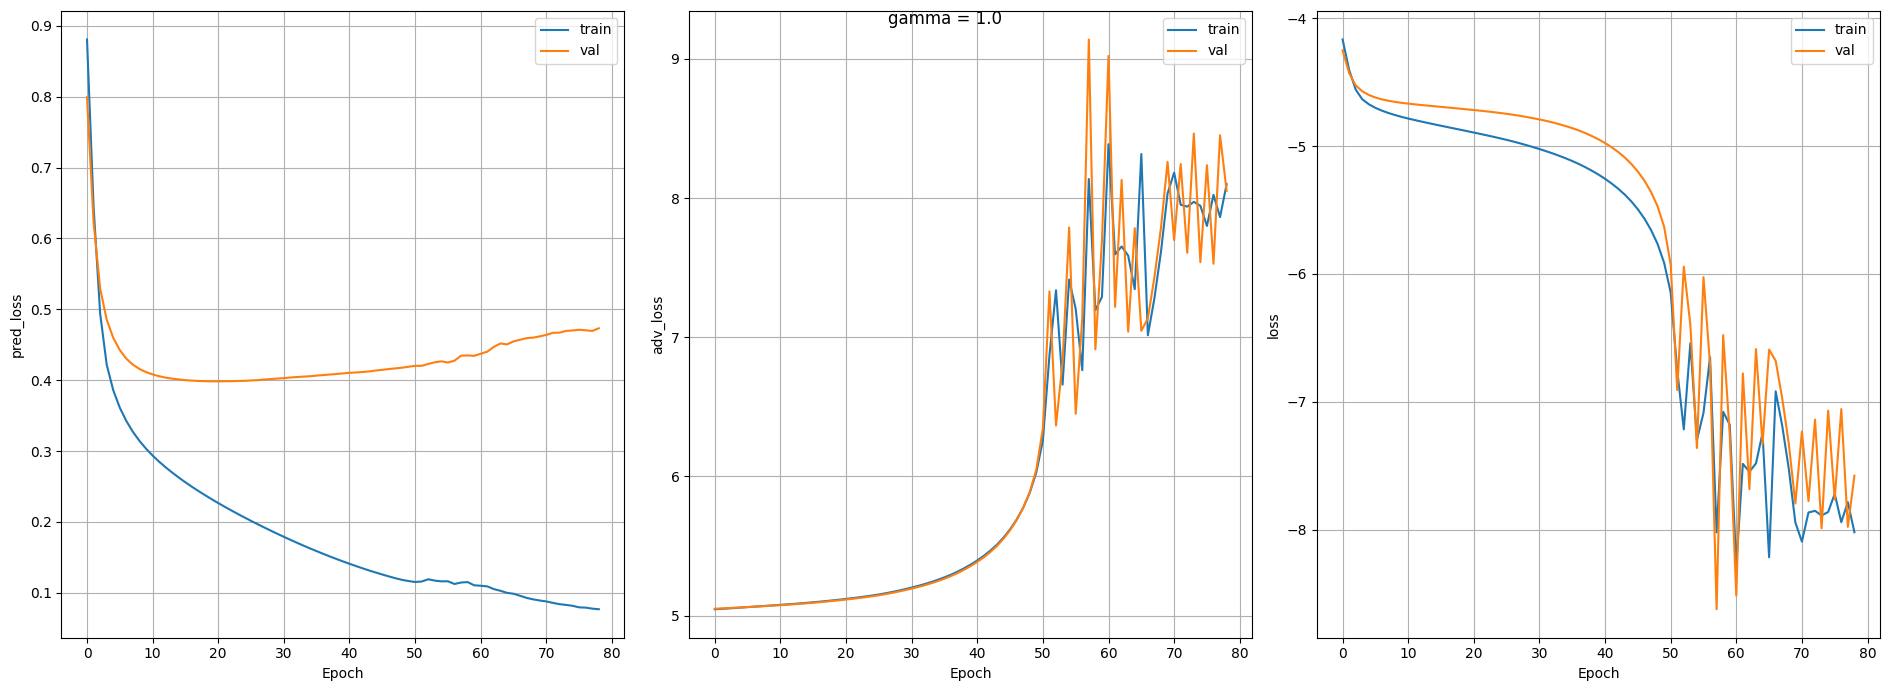

Early stopping!


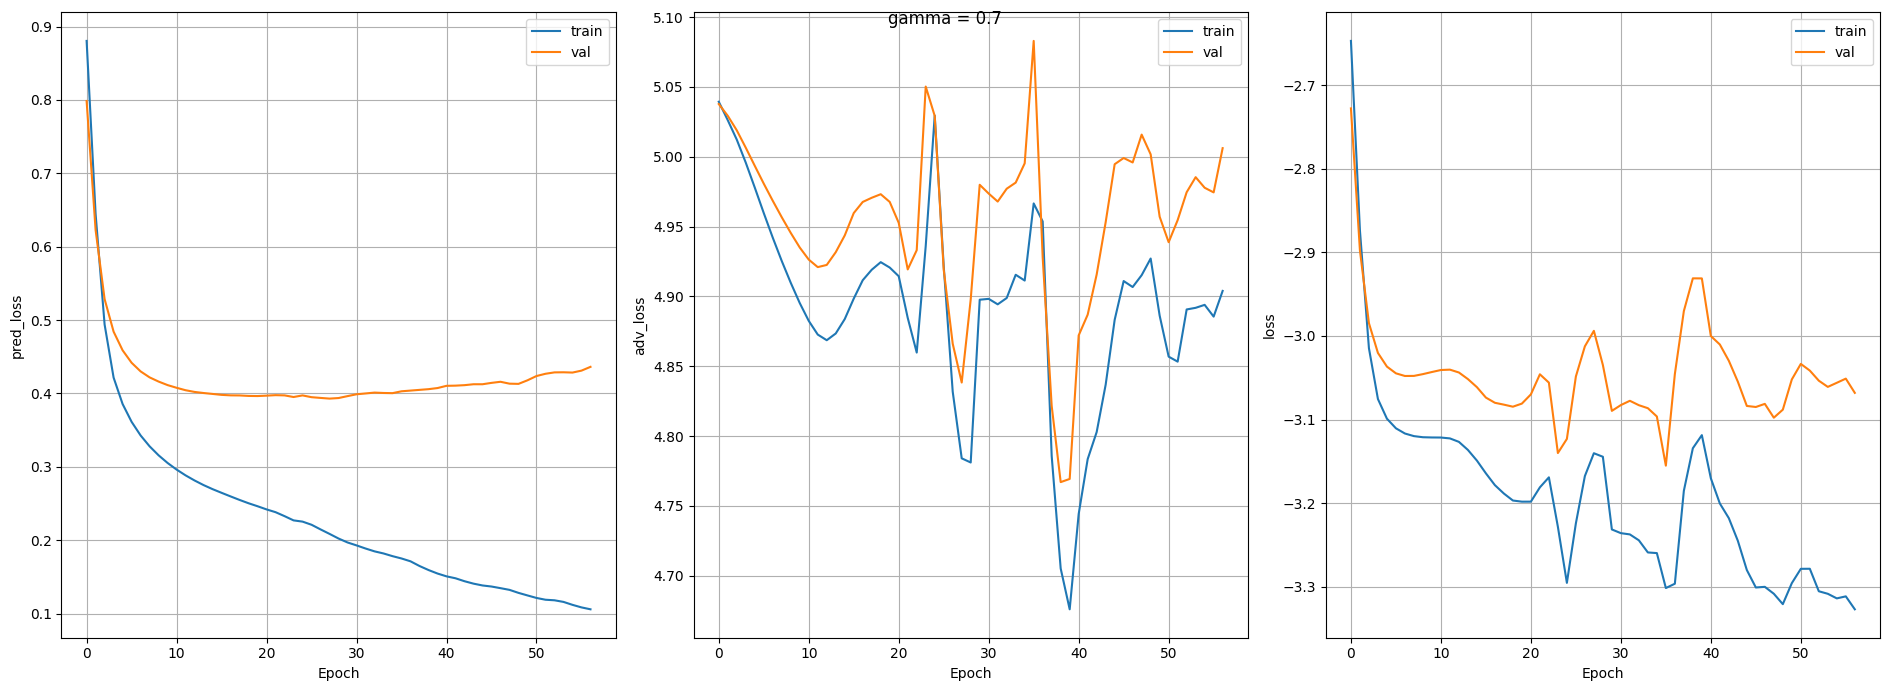

Early stopping!


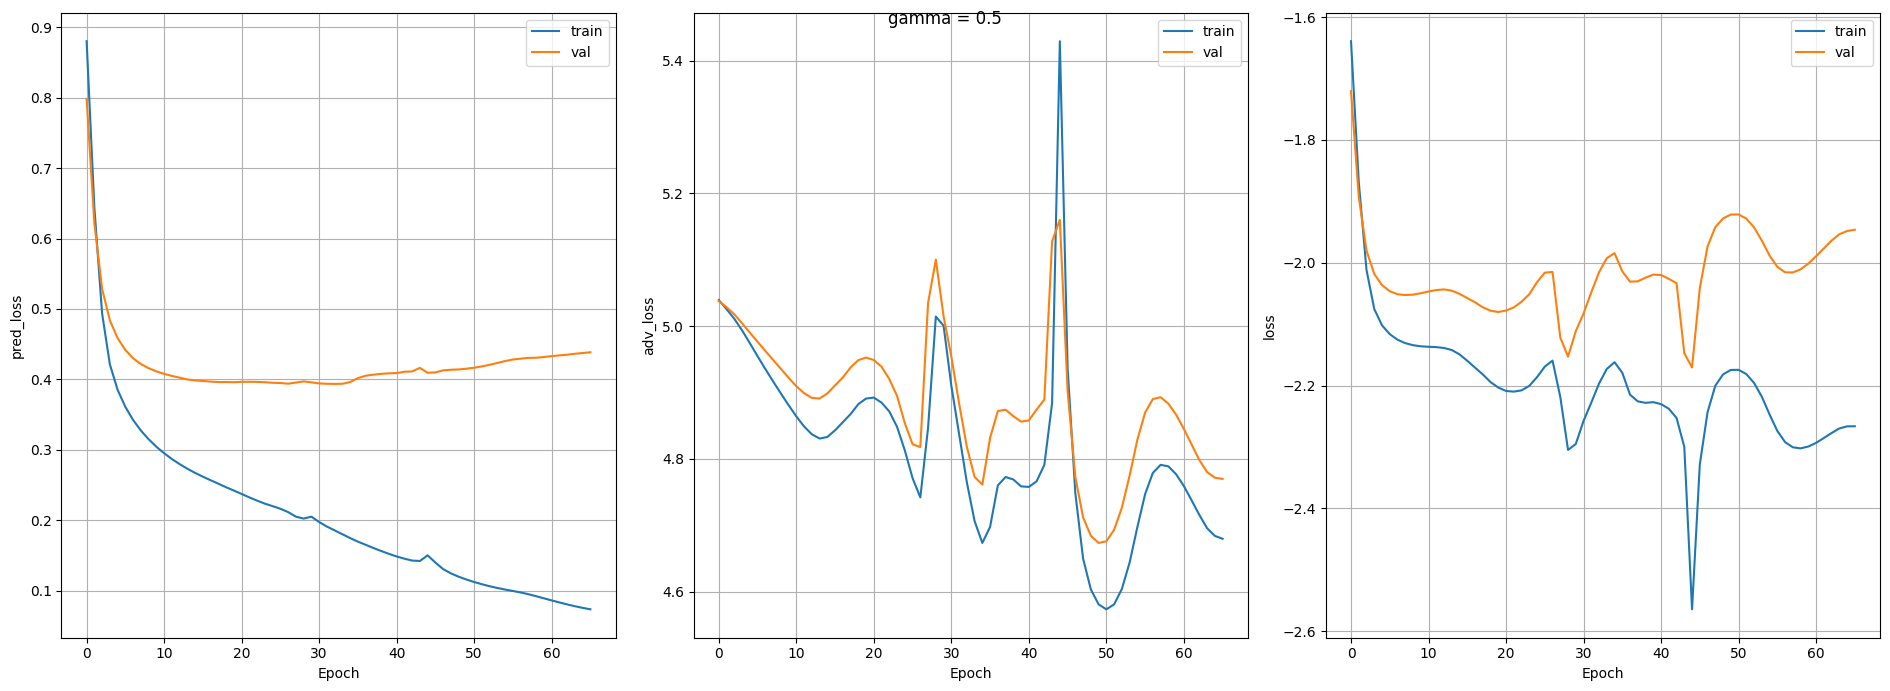

Early stopping!


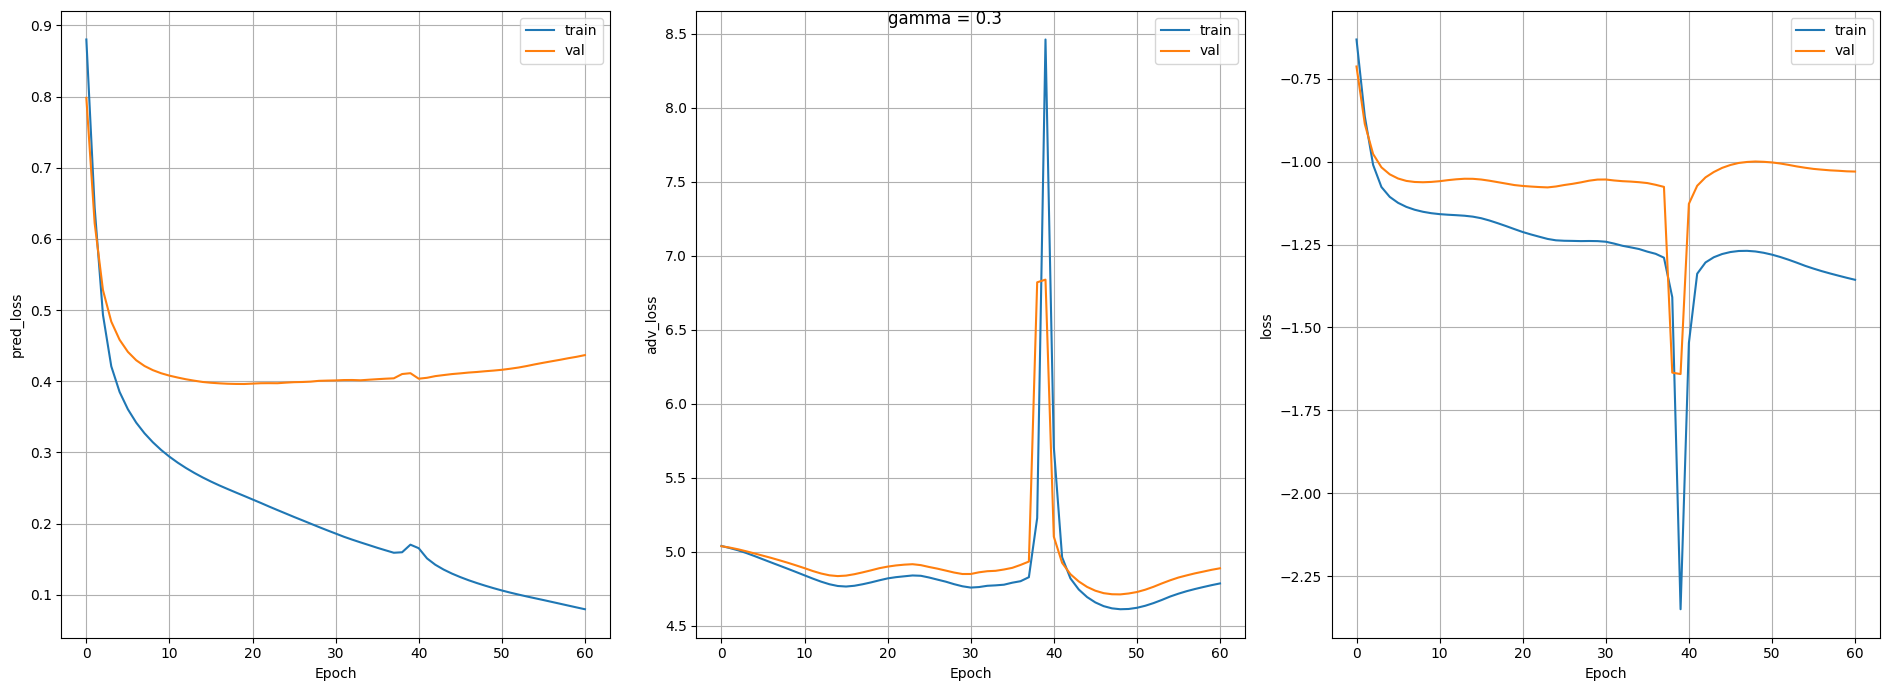

Early stopping!


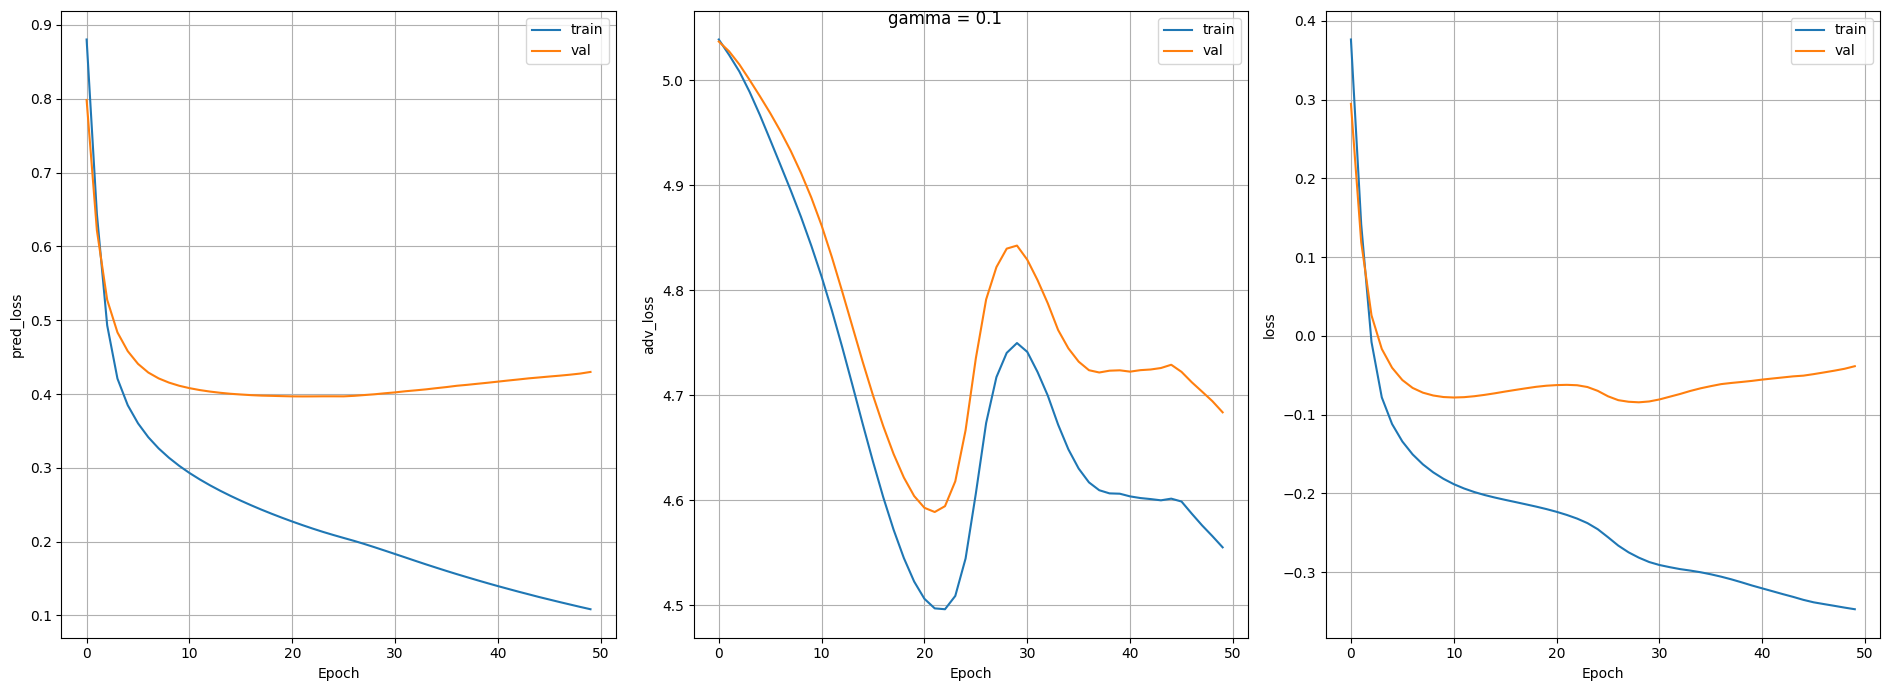

Early stopping!


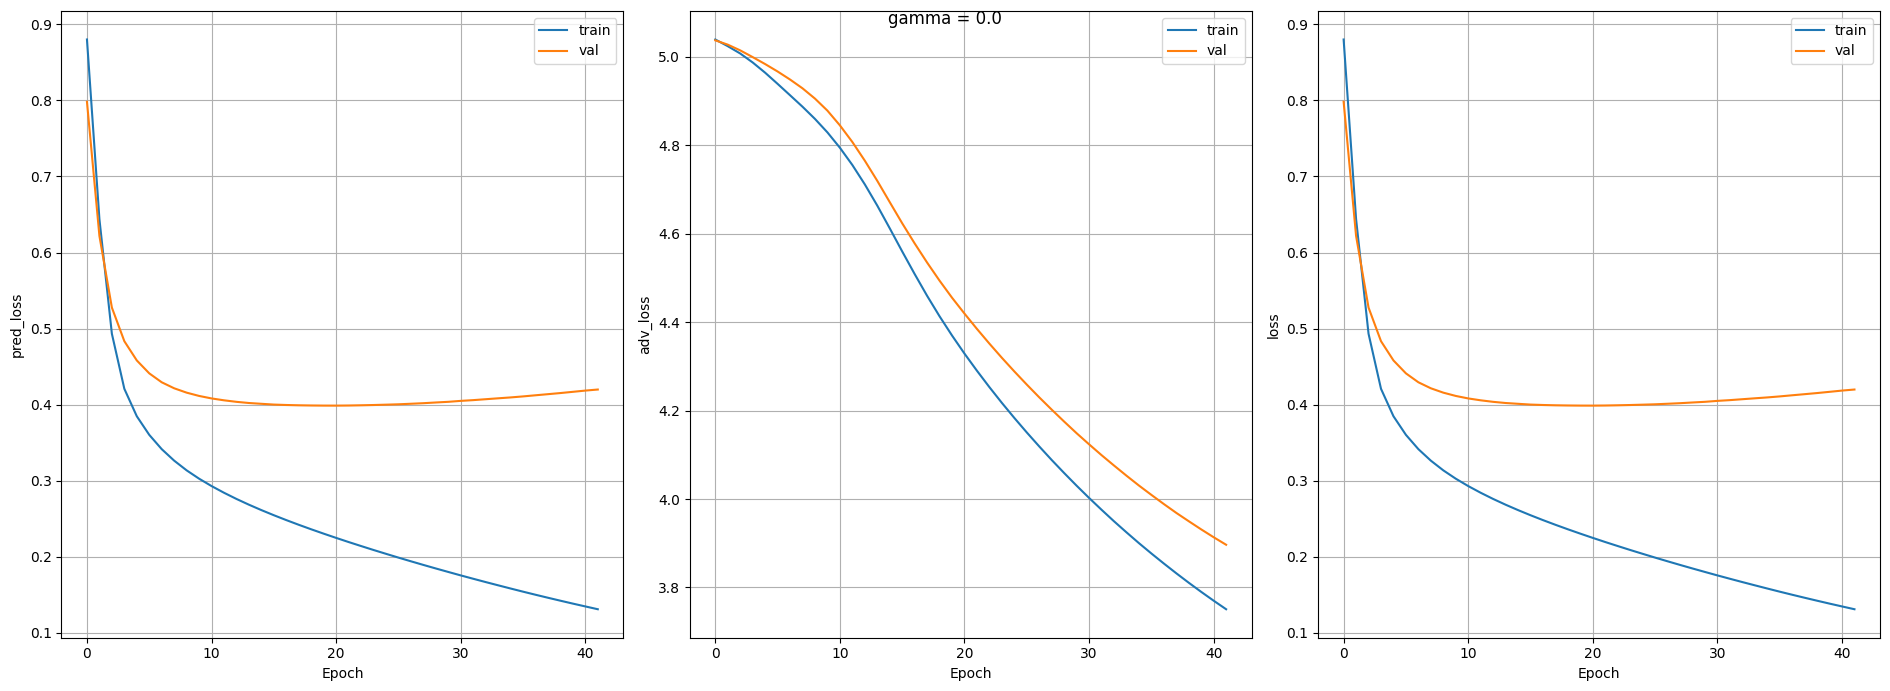

In [77]:
gammas = [0.0, 1e-1, 3e-1, 5e-1, 7e-1, 1.0][::-1]
for gamma in gammas:
    seed_everything(seed=42)
    device = torch.device("cuda:1")
    model = FairNN().to(device)
    trainer = Trainer(
        model = model,
        gamma = gamma,
        X_train = X_train_normalized,
        y_train = y_train_normalized,
        s_train = X_train_normalized['CNTSCHID'],
        X_val = X_val_normalized,
        y_val = y_val_normalized,
        s_val = X_val_normalized['CNTSCHID'],
        X_test = X_test_normalized,
        y_test = y_test_normalized,
        s_test = X_test_normalized['CNTSCHID'],
        model_name = 'fair_nn_v1',
        device = device
    )
    epochs = 150
    actual_epochs = trainer.train(
        epochs = epochs,
        batch_size = 32,
        patience = 20,
        verbose = False
    )
    trainer.plot_training_losses(actual_epochs)